In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as maps
import random
from tqdm import tqdm
from matplotlib import gridspec 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
# Parameter Configuration 
# -----------------------

nx   = 1001        # number of grid points in x-direction
xmax = 1000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
x    = dx* np.arange(nx); # spatial fabric


# Medium velocity
c_min= 200.;
c_max= 500.;
c0   = 334.         # wave speed in medium (m/s)
c    = np.zeros(nx)
c    = c + c0       # Homogeneous medium

#c[int(nx/3):int(2*nx/3)]= 0.5*c0
#c[int(nx/2):int(2*nx/3)]= 0.25* c0

# CPL Stability Criterion
eps= 0.8; # <1
dt= eps/c_max*dx; # Now we don't have to worry about the stability of the solution
nt   = 500          # maximum number of time steps
time = np.linspace(0 * dt, nt * dt, nt); # time fabric

print('dt= ', dt);
print('Duration of simulation would be ', time[-1], ' sec');

dt=  0.0016
Duration of simulation would be  0.8  sec


In [5]:
def space(x, cmax, cmin, dist_type= 'uniform', narrow_limit= 0.15):
  l= len(x);
  nl= int(narrow_limit*l);
  if dist_type== 'uniform':
    cout= (cmax+ cmin)/2* np.ones_like(x);
  elif dist_type== '2 parts':
    c1= random.randint(cmin, cmax);
    c2= random.randint(cmin, cmax);
    b1= random.randint(int(0.3333* l), int(0.667*l));
    cout= c1*np.ones_like(x);
    cout[b1:l]= c2;
  elif dist_type== '3 parts':
    c1= random.randint(cmin, cmax);
    c2= random.randint(cmin, cmax);
    c3= random.randint(cmin, cmax);
    b1= random.randint(int(0.25* l), int(0.5*l));
    b2= random.randint(b1, int(0.75*l));
    if b2-b1<nl:
      b2= b1+nl;
    cout= c1*np.ones_like(x);
    cout[b1:b2]= c2;
    cout[b2:l]= c3;
  elif dist_type== '4 parts':
    c1= random.randint(cmin, cmax);
    c2= random.randint(cmin, cmax);
    c3= random.randint(cmin, cmax);
    c4= random.randint(cmin, cmax);
    b1= random.randint(int(0.2* l), int(0.4*l));
    b2= random.randint(b1, int(0.6*l));
    if b2-b1<nl:
      b2= b1+nl;
    b3= random.randint(b2, int(0.8*l));
    if b3-b2<nl:
      b3= b2+nl;
    cout= c1*np.ones_like(x);
    cout[b1:b2]= c2;
    cout[b2:b3]= c3;
    cout[b3:l]= c4;
  elif dist_type== 'random':
    cout= cmin+ np.random.randn(l)*(cmax- cmin);

  return cout;


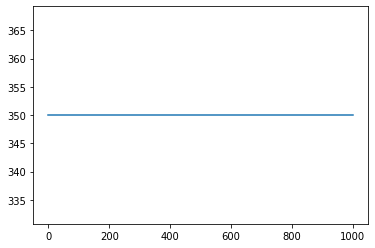

In [6]:
cx= space(x, cmax= c_max, cmin= c_min, dist_type= 'uniform')
maps.plot(x, cx)

In [10]:
def travel_time(dx, c, isrc, irec):
  l= dx/c;
  t= np.sum(l[min(isrc, irec):max(isrc, irec)]);
  return t;

In [ ]:
def avg_slowness(dx, c, isrc, irec):
  l= dx/c;
  t= np.sum(l[isrc:irec])#*np.sum(np.arange(min(isrc, irec), max(isrc, irec)));
  v= np.abs(irec-isrc)
  return t;
  

Transmission is easy but reflection can create havoc. The direction of the changed wave due to reflection makes matter bad, really bad. This and the transmission that occurs from the reflected wave and the amplitudes. </br>
Let's go with training the network with the analytical solution for homogeneous medium only. The point of extending the analytical solution to an inhomogeneous medium to '2 parts', and not '3 parts' or so on does not look to go well. We will sometime look for the complex algorithm that will give the analytical solution for inhomogeneous medium later on.

In [7]:
# Failed attempt at defining analytical solution for inhomogeneous medium

_= """


def G_fn(isrc, c, t):
  G= G_fn_homogeneous(isrc, c[isrc]*np.ones_like(c), t);
  # from isrc towards left

  T= [c[i]/(c[i]+c[i+1]) for i in range(isrc, len(c)-1)];
  R= [(c[i+1]-c[i])/(c[i]+c[i+1]) for i in range(isrc, len(c)-1)];

  # Transmission is easy
  G[isrc:-1]= T* G[isrc:-1];
  i= 0; # at source
  G[isrc-i]=1/(2*c[isrc-i]);
  while (True):
    i=i+1;
    if isrc-i>=0:
      T= 1;
      c1= c[isrc-i+1];
      c2= c[isrc-i];
      if not c2== c1:
        T= 2*c1/(c1+c2);
        G[isrc-i]= T*1/(2*c[isrc-i]);
      
  for i in range(0, len(c)):
    tt= travel_time(dx, c, isrc, i);
    if(t>=tt):
      G= 1/(2*c[i]);
      if isrc==i:
        G[i]= 1/2/c[i];
      else:
        tt_trans= 
        if 
        G[i]= tt/(dx*2*abs(isrc-i))#*(isrc-i))
        #abs(isrc-i)*1/2*1/np.sum(c[min(isrc, i):max(isrc, i)]);
  return G;"""

In [8]:
def G_fn_homogeneous(isrc, c, t):
  G= np.zeros_like(c);
  l_c= len(c)
  for i in range(0, len(c)):
    tt= travel_time(dx, c, isrc, i);
    if(t>=tt):
      G[i]= 1/(2*c[i]);
      tt_b1= travel_time(dx, c, i, 0);
      tt_b2= travel_time(dx, c, i, l_c);
      f1= True if t>=(tt+2*tt_b1) else False; # True if reflection from boundary B1 will also arrive
      f2= True if t>=(tt+2*tt_b2) else False; # True if reflection from boundary B2 will also arrive
      if f1 and f2:
        G[i]= -G[i];
      elif not f1 and not f2:
        G[i]= G[i];
      else:
        G[i]= 0.0;

  return G;

In [17]:
G= G_fn_homogeneous(400, cx, time[-100])
G= G/dt/10

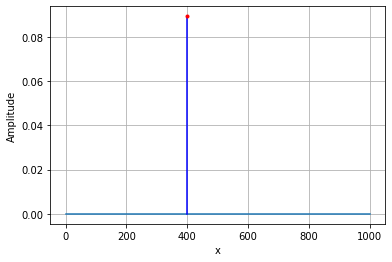

In [18]:
maps.plot(x, 0*x);
maps.plot(x[400]*np.array([1.,1.]), G[400]*np.array([0.,1.]), 'b-')
maps.plot(x[400], G[400], 'r.')
maps.xlabel('x');
maps.ylabel('Amplitude')
maps.grid('on')

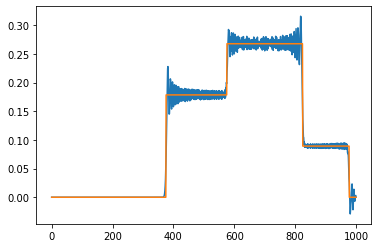

In [16]:
def generate_p(x, cx, p0):
  p= p0;
  P= np.zeros((nt, nx));
  pold= np.zeros_like(p);
  pnew= np.zeros_like(p);
  d2px = np.zeros(nx) # 2nd space derivative of p
  for it in range(nt):
      for i in range(1, nx - 1):
          d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2;

      pnew = 2 * p - pold + cx ** 2 * dt ** 2 * d2px;
      #pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2;
      pold, p = p, pnew;
      P[it,:]= pnew;
  
  return P;

p    = np.zeros(nx) # p at time n (now)
isrc= 800;
p[isrc]= 0.1;
p[600]= 0.2;
nt= 400
p= generate_p(x, cx, p)[-1,:]
maps.plot(x, p)
G= G_fn_homogeneous(isrc, cx, nt*dt)+ 2*G_fn_homogeneous(600, cx, nt*dt)
G= G/dt/10
maps.plot(x, G)


In [19]:
def get_p0(nsrc, x):
  l= len(x);
  i_srcs= [random.randint(150, 850) for i in range(0, nsrc)];
  srcs= 0.01* np.array([random.randint(0, 100) for i in range(0, nsrc)]);
  p= np.zeros_like(x);
  p[i_srcs]= srcs;
  return [i_srcs, srcs];

In [20]:
def get_G(x, cx, isrcs, srcs, nt):
  P_i= np.zeros((nt, nx));
  for t in range(0,nt):
    pi= [srcs[i]/0.1*G_fn_homogeneous(isrcs[i], cx, t*dt) for i in range(0, len(srcs))];
    pi= np.sum(np.array(pi), axis= 0);
    P_i[t]= pi;
  
  return P_i;

In [21]:
sample= 1;
pred_t_len= 20; # we predict the next 20 time steps
each_samp= 25; # we pick 25 sample points from each (cx,p0) distribution
Px= np.zeros((each_samp*sample, nx));
Py= np.zeros((each_samp*sample, pred_t_len, nx));
C= np.zeros_like(Px);
for i in tqdm(range(0, sample)):
  dist_type= 'uniform';
  cx= space(x, cmax= c_max, cmin= c_min, dist_type= dist_type);
  nsrc= random.randint(1, 10);
  [isrcs, srcs]= get_p0(nsrc, x);
  P_i= get_G(x, cx, isrcs, srcs, nt);
  #P_i= generate_p(x, cx, p0); # (nt, nx)= (500, 1001)
  pick_sample= [random.randint(0, nt-each_samp-5) for i in range(0, each_samp)];
  px= P_i[pick_sample, :]; #(each_samp, nt) where we are picking each_samp (25) data points for the current cx, p0 distribution
  #px= np.expand_dims(px, axis= 1);
  py= np.array([P_i[pick_sample[i]+1: pick_sample[i]+pred_t_len+1, :] for i in range(0, len(pick_sample))]);
  #print(px.shape, py.shape);
  Px[each_samp*i:each_samp*(i+1),:]= px;
  Py[each_samp*i:each_samp*(i+1),:,:]= py;
  C[each_samp*i:each_samp*(i+1),:]= cx;
  #break;
  #P[50*i:50*(i+1),:]= P_i[pick_sample, :];
  #if i%each_samp==0:
    #print("%d/%d" %(i*each_samp, sample*each_samp))


100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


In [ ]:
np.savez_compressed("/content/drive/MyDrive/wave_sim/G1_X_data.npz", X= Px)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/wave_sim/G1_C_data.npz", C= C)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/wave_sim/G1_Y_data.npz", Y= Py)